In [1]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
    using_TPU = True    # If we are running this notebook on Colab, use a TPU
    # Import functions to update cloud bucket. 
    # Key for using Google cloud services is on personal drive
    from google.cloud import storage
    # Google cloud credentials
    %env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/Uni/Magistrale/NLP/Project/nlp-project-338723-0510aa0a4912.json
except:
    IN_COLAB = False
    using_TPU = False   # If you're not on Colab you probably won't have access to a TPU

# Description

In this notebook, we will try to implement the architecture detailed in [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf). 

The idea is that we have a corpus of documents $C = {p_1, p_2, \dots, p_M}$ where each passage $p_i$ can be viewed as a sequence of tokens $w_1^{(i)}, w_2^{(i)}, \dots, w_{|p_i|}^{(i)}$ and given a question $q$ we want to find the sequence of tokens $w_s^{(i)}, w_{s+1}^{(i)}, \dots, w_{e}^{(i)}$ from one of the passage $i$ that can answer the question.

In order to find the passage $i$ we need an efficient **Retriever** (i.e. a function $R: (q, C) \rightarrow C_F$ where $C_F$ is a very small set of $k$ documents that have a high correlation with the query.)

In the Tf-Idf example, the retriever was simply a function that returned the top score obtained by computing the vector cosine similarity between the query and all other documents. The problem with this approach is that it is not very efficient. Tf-Idf is a **sparse** document/query representation, thus computing a multitude of dot products between these very long vectors can be expensive.

The paper cited above proposes a **dense** representation instead. It uses a Dense Encoder $E_P$ which maps all paragraphs to $d$-dimensional vectors. These vectors are stored in a database so that they can be efficiently retrieved. 

At run-time, another Dense Encoder $E_Q$ is used: it maps the input question to a vector with the same dimensionality $d$. Then, a similarity score is computed between the two representations:

$sim(p,q) = E_Q(q)^\intercal E_P(p)$

In the paper, $E_Q$ and $E_P$ are two independent BERT transformers and the $d$-dimensional vector is the **output at the $\texttt{[CLS]}$ token** (so, $d = 768$).
- This leaves open the possibility to use a larger dimensionality (eg. concatenating the output at multiple blocks like we did for the QA task).

<!-- The $d$-dimensional representations of the $M$ passages are indexed using [FAISS](https://github.com/facebookresearch/faiss), an efficient, open-source library for similarity search and clustering of dense vectors developed at Facebook AI.  -->
At run-time, we simply compute $v_q = E_Q(q)$ and retrieve the top $k$ passages with embeddings closest to $v_q$.

In this case, training the network means solving a **metric learning** problem: the two BERT networks need to learn an **effective vector space** such that relevant pairs of questions and passages are close, while irrelevant pairs are placed further away. In this problem we usually build a **training instance $D$** as ${(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-)}^m_{i=1}$, where question $q$ is paired with a relevant (positive) passage $p_i^+$ and $n$ irrelevant (negative) passages. Then, the loss function is the negative log-likelihood of the positive passage:

$L(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-) = -\log\frac{e^{sim(q_i, p_i^+)}}{e^{sim(q_i, p_i^+)} + \sum_{j=1}^n e^{sim(q_i, p_{i,j}^-)}}$

It's easy to find the positive paragraph, but choosing the negatives is quite important. In particular, the paper proposes different ways for sampling the negatives:
- Random: a negative is any random passage in the corpus
- TF-IDF (The paper uses a variant, BM25): the negatives are the top passages (not containing the answer) returned by a TF-IDF search
- Gold: the negatives are positives for other questions in the mini-batch. For the researchers, this is the best negative-mining option, because it's the most efficient and also it makes a batch a complete unit of learning (we learn the relationship that each question in the batch has with the other paragraphs).

The Gold method allows the **in-batch negatives** technique: assuming to have a batch size of $B$, then we collect two $B \times d$ matrices (one for questions, one for their positive paragraphs). Then, we compute $S = QP^\intercal$ which is a $B \times B$ matrix of **similarity scored** between each question and paragraph. This matrix can directly be used for training: any ($q_i, p_j$) pair where $i = j$ is considered to be a positive example, while it's negative otherwise. In total there will be $B$ training instances per batch, each with $B-1$ negative passages. 

Furthermore, at least one of the $B-1$ negative passages should be hard enough, so that the model learns to discriminate well. We pick the first non-positive paragraph returned by a Tf-Idf vectorizer and replace a random negative in the batch with it.

# Configuration

## Imports

In [2]:
import os
import time
import numpy as np
import random
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union, Dict, Tuple
from transformers import BertTokenizerFast, DistilBertTokenizerFast, \
                         TFBertModel, TFDistilBertModel
from sklearn.feature_extraction.text import TfidfVectorizer

import utils

RANDOM_SEED = 42
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### TPU check
The training could be made faster if we use the cloud GPUs offered by Google on Google Colab. Since TPUs require manual intialization and other oddities, we check multiple times throughout the notebook what kind of hardware we are running the code on.

In [3]:
if using_TPU:
    try: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print("TPUs are not available, setting flag 'using_TPU' to False.")
        using_TPU = False
        print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

BATCH_SIZE = 8 if not using_TPU else 128

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


## Allowed operations

In [7]:
ANALYSE_TOKENIZATIONS = True    # Tokenises all paragraphs and showcases a simple analysis
                                # for reducing the length of the sequence. Runs in less 
                                # than a few minutes on any architecture.

OVERWRITE_DATASETS = False      # Best to be run on GPU, takes about half an hour.
                                # It saves a new copy of the pre-tokenized
                                # question-paragraph pair on Google Drive.
                                # The copy should then be uploaded to GCloud into
                                # the bucket allocated for the project to be used by
                                # TPUs.

DO_TRAINING = True              # Best to be run on TPU, takes about 2 hours.
                                # It trains the model and saves a copy of the 
                                # last weights on Google Drive. When run on GPU
                                # It also saves checkpoints and Tensorboard data,
                                # but it takes over 4 hours to do a single epoch,
                                # so it's impossible to run it on Colab.

OVERRIDE_REPRESENTATIONS = True  # Best to be run on GPU, it takes about 30 minutes.
                                 # It produces representations of all paragraphs
                                 # using the trained model_p as a large NumPy array
                                 # that is stored on Google Drive at the end.

OVERRIDE_SCORES = False          # Produces scores for all paragraphs for each question in each set
                                 # using the dpr and tf-idf, used to compute metrics. Takes up a LOT
                                 # of RAM

RUN_ACCURACY_ANALYSIS = True    # Best to be run on GPU, takes about 30 minutes.
                                # It analyzes the paragraph retrieval capability
                                # of the model with top-1 to top-100 accuracy.

## Variables

We define all the paths.

In [29]:
ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
VALIDATION_FILE = os.path.join(ROOT_PATH, 'data', 'validation_set.json')
TEST_FILE = os.path.join(ROOT_PATH, 'data', 'dev_set.json')

In [31]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    checkpoint_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/'
    datasets_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/datasets/dpr/'
else:
    # Create the folder where we'll save the weights of the model
    checkpoint_dir = os.path.join("checkpoints", "training_dpr")
    datasets_dir = os.path.join(ROOT_PATH, "data", "training_dpr", "dataset")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

We collect the training, validation and testing questions and paragraphs.

In [4]:
from utils import get_questions_and_paragraphs

train_paragraphs_and_questions = utils.read_question_set(TRAINING_FILE)['data']
val_paragraphs_and_questions = utils.read_question_set(VALIDATION_FILE)['data']
test_paragraphs_and_questions = utils.read_question_set(TEST_FILE)['data']

# Remove the validation set from the train set
train_paragraphs_and_questions = [article for article in train_paragraphs_and_questions \
                                  if article not in val_paragraphs_and_questions]

train_questions, train_paragraphs = get_questions_and_paragraphs(train_paragraphs_and_questions)
val_questions, val_paragraphs = get_questions_and_paragraphs(val_paragraphs_and_questions)
test_questions, test_paragraphs = get_questions_and_paragraphs(test_paragraphs_and_questions)

print(f"Number of training questions: {len(train_questions)}")
print(f"Number of training paragraphs: {len(train_paragraphs)}")
print()
print(f"Number of val questions: {len(val_questions)}")
print(f"Number of val paragraphs: {len(val_paragraphs)}")
print()
print(f"Number of test questions: {len(test_questions)}")
print(f"Number of test paragraphs: {len(test_paragraphs)}")

Number of training questions: 65064
Number of training paragraphs: 13975

Number of val questions: 22535
Number of val paragraphs: 4921

Number of test questions: 10570
Number of test paragraphs: 2067


We create the two different DistilBert models for encoding and test them on a random question/paragraph.

In [ ]:
tokenizer_distilbert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

model_q, model_p = TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                   TFDistilBertModel.from_pretrained('distilbert-base-uncased')

What is the ideal maximum length of a sequence of tokens?

In [ ]:
if ANALYSE_TOKENIZATIONS:
    lens = []
    for paragraph in tqdm(train_paragraphs):
        emb = tokenizer_distilbert(paragraph['context'], return_tensors='np')
        tokens = emb['attention_mask'].shape[1]
        lens.append(tokens)
    print(f"Total n. of paragraphs: {len(train_paragraphs)}")
    for i in range(350, 500, 10):
        print(f"Only {np.sum(np.asarray(lens) > i)} are truncated when using {i} max tokens ({np.sum(np.asarray(lens) > i) / len(train_paragraphs)*100}%)")

100%|██████████| 13975/13975 [00:06<00:00, 2150.24it/s]

Total n. of paragraphs: 13975
Only 184 are truncated when using 350 max tokens (1.3166368515205724%)
Only 156 are truncated when using 360 max tokens (1.1162790697674418%)
Only 132 are truncated when using 370 max tokens (0.9445438282647585%)
Only 119 are truncated when using 380 max tokens (0.851520572450805%)
Only 100 are truncated when using 390 max tokens (0.7155635062611807%)
Only 84 are truncated when using 400 max tokens (0.6010733452593918%)
Only 68 are truncated when using 410 max tokens (0.48658318425760283%)
Only 58 are truncated when using 420 max tokens (0.4150268336314848%)
Only 46 are truncated when using 430 max tokens (0.3291592128801431%)
Only 39 are truncated when using 440 max tokens (0.27906976744186046%)
Only 35 are truncated when using 450 max tokens (0.25044722719141327%)
Only 30 are truncated when using 460 max tokens (0.2146690518783542%)
Only 28 are truncated when using 470 max tokens (0.2003577817531306%)
Only 27 are truncated when using 480 max tokens (0.19

To reduce memory consumption, we can:
- Truncate sequences at something like 380 tokens (less than 1% of the total training paragraphs would be cut with this decision)
- Reduce the dimensionality of Bert/DistilBert's output to `BERT_DIMENSIONALITY` (instead of the default of 768).

In [10]:
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768

If we decide to reduce the dimensionality, we can add a `Dense` layer on top of the encoder. This layer reduces the dimension of the output to whatever we need.

In [8]:
from utils import ReducedDistilBertModel

model_q = ReducedDistilBertModel(model_q)
model_p = ReducedDistilBertModel(model_p)

Let's try this model on a test question:

In [10]:
test_question = train_questions[0]['qas']['question']
print(f"Testing on a simple question. \nQuestion: {test_question}")
inputs_test = tokenizer_distilbert(test_question, return_tensors="tf")
outputs = model_q(inputs_test)

# As a representation of the token we use the last hidden state at the [CLS] token (the first one)
test_q_repr = outputs[0,0,:]
print(f"Representation dimensionality: {test_q_repr.shape}")

Testing on a simple question. 
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Representation dimensionality: (768,)


We also create the Tf-Idf vectorizers for the training and validation sets.

In [ ]:
train_val_paragraphs = train_paragraphs + val_paragraphs

In [11]:
final_vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, max_df=0.8, norm='l2')

Transform all paragraphs into a vectorized representation.

In [12]:
final_vectorizer = final_vectorizer.fit([train_val_paragraphs[i]['context'] for i in range(len(train_val_paragraphs))])
train_docs_vect  = final_vectorizer.transform([train_paragraphs[i]['context'] for i in range(len(train_paragraphs))])
val_docs_vect    = final_vectorizer.transform([val_paragraphs[i]['context'] for i in range(len(val_paragraphs))])
test_docs_vect   = final_vectorizer.transform([test_paragraphs[i]['context'] for i in range(len(test_paragraphs))])

For each question in these sets, obtain its highest scoring negative.

In [13]:
def get_best_negative_paragraph_for_question(question, vectorizer, docs_vet, paragraphs):
    # Get the groundtruth paragraph for the question
    gt_paragraph, _ = question['context_id']
    # Transform the question into a vector
    vect_question = vectorizer.transform([question['qas']['question']])
    # Compute similarities with the input matrix of representations
    similarities = np.asarray(np.dot(docs_vet, vect_question.T).todense()).flatten()
    # Obtain the best scoring indices and remove the groundtruth index
    best_scoring_paragraph_indices = np.argsort(-similarities)
    best_scoring_paragraph_indices = best_scoring_paragraph_indices[
        best_scoring_paragraph_indices != gt_paragraph]
    best_negative = best_scoring_paragraph_indices[0]
    # Return the corresponding paragraph
    return paragraphs[best_negative]

In [14]:
get_best_negative_paragraph_for_question(
    train_questions[0], final_vectorizer, train_docs_vect, train_paragraphs)

{'context': ' In Methodism, Mary is honored as the Mother of God. Methodists do not have any additional teachings on the Virgin Mary except from what is mentioned in Scripture and the ecumenical Creeds. As such, Methodists believe that Mary was conceived in her womb through the Holy Ghost and accept the doctrine of the Virgin Birth, although they, along with Orthodox Christians and other Protestant Christians, reject the doctrine of the Immaculate Conception. John Wesley, the principal founder of the Methodist movement within the Church of England, believed that Mary "continued a pure and unspotted virgin", thus upholding the doctrine of the perpetual virginity of Mary. Contemporary Methodism does hold that Mary was a virgin before, during, and immediately after the birth of Christ. In addition, some Methodists also hold the doctrine of the Assumption of Mary as a pious opinion.',
 'context_id': (114, 20)}

This is indeed a hard negative, because it talks about Mary and Christian religion just like the grondtruth paragraph:

In [15]:
train_paragraphs[0]

{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'context_id': (0, 0)}

# Dataset creation

First of all, we need to train our models. To do that, we need to create a dataset that feeds batches of questions and positive and negative paragraphs to our model. The model is then used to compute the representations of the questions/paragraphs and through the representations we can compute the similarities and correct the learnt distributions from the encoder models.

For the dataset, we use the `tf.data.Dataset` API. In particular, we first create the dataset in a `.proto` file which contains all the information in a byte format. The file is then uploaded on Google Cloud, where it can easily be accessed all future times. This is the only working way to have a large dataset accessible from the TPU.

In [20]:
from utils import get_paragraph_from_question, decode_dataset_fn

def pre_tokenize_data(questions, dataset, tokenizer):
    # Pre-tokenizes questions and paragraphs
    tokenized_questions = [
        dict(tokenizer(questions[i]['qas']['question'], 
            max_length = MAX_SEQ_LEN, truncation = True, 
            padding = 'max_length'))
        for i in tqdm(range(len(questions)))]
    tokenized_paragraphs = [
        dict(tokenizer(get_paragraph_from_question(
                    questions[i], dataset
                )['context'], max_length = MAX_SEQ_LEN, 
            truncation = True, padding = 'max_length',
            return_offsets_mapping = True))             # For the paragraphs we need the offset mappings too
        for i in tqdm(range(len(questions)))]
    return tokenized_questions, tokenized_paragraphs

def find_start_end_token_one_hot_encoded(
    answers: Dict, 
    offsets: List[Tuple[int]]) -> Dict:
    '''
    This function returns the starting and ending token of the answer, 
    already one hot encoded and ready for binary crossentropy.
    Inputs:
        - answers: `List[Dict]` --> for each question, a list of answers.
            Each answer contains:
            - `answer_start`: the index of the starting character
            - `text`: the text of the answer, that we exploit through the 
                number of chars that it contains
        - offsets: `List[Tuple[int]]` --> the tokenizer from HuggingFace 
            transforms the paragraph into a sequence of tokens. 
            Offsets keeps track of the character start and end indexes for each token.
   
    Output:
        - result: `Dict` --> each key contains only one array, the one-hot 
            encoded version of, respectively, the start and end token of 
            the answer in the sentence (question+context)
    '''
    result = {
        "out_S": np.zeros(len(offsets), dtype=np.int32),
        "out_E": np.zeros(len(offsets), dtype=np.int32)
    } 
    for answer in answers:
        starting_char = answer['answer_start']
        answer_len = len(answer['text'])
        # We skip the first token, [CLS], that has (0,0) as a tuple
        for i in range(1, len(offsets)):
            # Check if starting char is within the indexes
            if (starting_char >= offsets[i][0]) and \
                (starting_char <= offsets[i][1]):
                result["out_S"][i] += 1
            # If the ending char (starting + length -1) is in the interval, 
            # same as above.
            if (starting_char + answer_len - 1 >= offsets[i][0]) and \
                (starting_char + answer_len - 1 < offsets[i][1]):
                result["out_E"][i] += 1
                break
    return result

def create_dataset_from_records(questions, paragraphs, dataset, tokenizer, 
                                fn, vectorizer, docs_vect, batch_size=BATCH_SIZE):
    # Prepare strings
    filename = f'{fn}_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    dst_name = fn_type + '.proto'
    bucket_name = 'volpepe-nlp-project-squad-datasets'
    gcs_filename = f'gs://{bucket_name}/{dst_name}'
    # If we want to write a new dataset or overwrite one with the same name:
    if OVERWRITE_DATASETS:
        print("Pre-tokenizing data...")
        tok_questions, tok_paragraphs = pre_tokenize_data(questions, dataset, tokenizer)
        assert len(tok_questions) == len(tok_paragraphs), "Error while pre-tokenizing dataset"
        print("Preprocessing answers...")
        answer_tokens = [find_start_end_token_one_hot_encoded(
            questions[i]['qas']['answers'], tok_paragraphs[i]['offset_mapping'])
            for i in tqdm(range(len(questions)))]
        print("Saving dataset on disk...")
        with tf.io.TFRecordWriter(filename) as file_writer:
            for i in tqdm(range(len(tok_questions))):
                hard_paragraph = get_best_negative_paragraph_for_question(questions[i], vectorizer, docs_vect, paragraphs)
                tok_hard_paragraph = dict(tokenizer(hard_paragraph['context'], 
                                                    max_length = MAX_SEQ_LEN, 
                                                    truncation = True, 
                                                    padding = 'max_length',
                                                    return_offsets_mapping = False))
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    "question__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["input_ids"])),
                    "question__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["attention_mask"])),
                    "question__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[i])),
                    "answer__out_s": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_S"])),
                    "answer__out_e": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_E"])),
                    "paragraph__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["input_ids"])),
                    "paragraph__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["attention_mask"])),
                    "hard_paragraph__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_hard_paragraph['input_ids'])),
                    "hard_paragraph__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_hard_paragraph['attention_mask'])),
                    "paragraph__tokens_s": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[0] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "paragraph__tokens_e": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[1] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "context__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[questions[i]['context_id'][0]])),
                    "paragraph__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[questions[i]['context_id'][1]]))
                    })).SerializeToString()
                file_writer.write(record_bytes)
        # Upload the dataset on cloud
        print(f"Uploading {filename} on {gcs_filename} (bucket {bucket_name}) with name {dst_name}")
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(dst_name)
        blob.upload_from_filename(filename)
        time.sleep(5)   # Wait 5 seconds
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_dataset_fn)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

### CREATE DATASETS ###
# Valid for both TPU and GPU
dataset_train = create_dataset_from_records(train_questions, train_paragraphs, train_paragraphs_and_questions, 
                                            tokenizer_distilbert, os.path.join(datasets_dir, 'train'),
                                            final_vectorizer, train_docs_vect)
dataset_val = create_dataset_from_records(val_questions, val_paragraphs, val_paragraphs_and_questions, 
                                          tokenizer_distilbert, os.path.join(datasets_dir, 'val'),
                                          final_vectorizer, val_docs_vect)

Loading train_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/train_768.proto).
Loading val_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/val_768.proto).


# Training pipeline

First of all, we need a layer that takes as input the dictionary containing the tokenized questions and answers and returns their compact representations.

In [21]:
from utils import DenseEncoder

# Small test for the layer
class TestDenseEncoderModel(keras.Model):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        return self.enc(inputs, training=training)

test_model = TestDenseEncoderModel(model_q, model_p)
q_repr, p_repr, p_hard_repr = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=True)
print(f"Output shape when in training mode: {q_repr.shape}, {p_repr.shape}, {p_hard_repr.shape}")
q_repr_2 = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=False)
print(f"Output shape when in testing mode: {q_repr_2.shape}")
q = tokenizer_distilbert(
    train_questions[0]['qas']['question'], max_length = MAX_SEQ_LEN, 
    truncation = True, padding = 'max_length', return_tensors="tf")
q_repr_3 = test_model({'questions': q})
print(f"Output shape when dealing with a single question: {q_repr_3.shape}")

Output shape when in training mode: (128, 768), (128, 768), (128, 768)
Output shape when in testing mode: (128, 768)
Output shape when dealing with a single question: (1, 768)


Once we have the representations, we should compute the similarities, thus obtaining a a full mini-batch of positive-negative examples.

In [19]:
# Create the similarity matrix
S = tf.tensordot(q_repr, tf.transpose(p_repr), axes=1)
S.shape

TensorShape([128, 128])

This similarity matrix has the following meaning:
- Rows represent questions.
- Each element in the row contains the similarity that the respective question has with the paragraphs in the batch (paragraphs are on the columns and one of them is the positive one, the others are negative)

To this matrix, we want to append the score that the paragraphs have with the hard paragraphs. To do that we:
- One by one, we compute the score that each question representations has with the corresponding hard paragraph.
- We append these scores to the original $8\times8$ matrix, obtaining a $8\times9$ matrix of similarities. 

In [20]:
hard_scores = tf.gather(
    # Get the elements on the diagonal of the 8x8 matrix of scores between questions and 
    # hard paragraphs
    tf.tensordot(q_repr, tf.transpose(p_hard_repr), axes=1), 
    tf.expand_dims(tf.range(BATCH_SIZE), axis=1), batch_dims=1)
hard_scores.shape

TensorShape([128, 1])

In [21]:
complete_S = tf.concat([S, hard_scores], axis=1)
complete_S.shape

TensorShape([128, 129])

Note: the groundtruth value are still the ones from 1 to 8, so this does not damage the loss computation.

In the paper, they refer to the loss as a *minimization of the negative log-likelihood of the positive passage*: what it really means is that we need to transform similarities to probabilities and use a categorical cross-entropy loss, where labels are the row index (which is also the column index in that row for the positive passage)

In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
loss(y_true=tf.range(BATCH_SIZE), y_pred=complete_S).numpy()

11.2015

The loss seems to be quite high for this batch. We can study it with a confusion matrix.

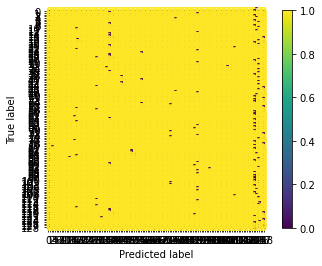

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

S_arr = complete_S.numpy()
ConfusionMatrixDisplay.from_predictions(y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Indeed, ideally the predictions should be on the diagonal. This means that the "default" space for this metric learning problem is not that good. We are ready to learn a new representation distribution.

# Model definition

In [22]:
from utils import DeepQPEncoder

def create_model(sample, freeze_layers_up_to=5):
    print("Creating BERT models...")
    model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                        TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Freeze layers 
    for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
        model_q.distilbert.transformer.layer[i].trainable = False
        model_p.distilbert.transformer.layer[i].trainable = False

    model_q, model_p = ReducedDistilBertModel(model_q), ReducedDistilBertModel(model_p)

    print("Creating Deep Encoder...")
    model = DeepQPEncoder(model_q, model_p)

    print("Compiling...")
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    print("Testing on some data...")
    # Pass one batch of data to build the model
    model(sample)

    # Return the model
    print("Model created!")
    return model

# Training

Define utility variables and saving paths.

In [ ]:
EPOCHS = 200
PATIENCE = 20

Before training, we check if we're using a TPU, in order to create the model within the scope of the strategy.

Then, we train the model.

In [23]:
import datetime

# GPUs and local systems don't need the above specifications. We simply
# create a pattern for the filename and let the callbacks deal with it.
model_name = f'dpr_{BERT_DIMENSIONALITY}_hard'
checkpoint_path = os.path.join(checkpoint_dir, model_name + ".ckpt")
# Workaraound for saving locally when using cloud TPUs
local_device_option = tf.train.CheckpointOptions(
    experimental_io_device="/job:localhost")

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)
else:
    # On TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        f"training_dpr_{BERT_DIMENSIONALITY}_hard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

Creating BERT models...


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

Creating Deep Encoder...
Compiling...
Testing on some data...
Model created!


In [ ]:
if DO_TRAINING:
    if not using_TPU:
        # Tensorboard callback is not available on TPU
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    
    # ModelCheckpoint callback is available both on TPU and GPU 
    # with the options parameter
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        verbose=1,
        save_weights_only = True,
        save_best_only = True,
        options=local_device_option
    )

    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = PATIENCE,
        restore_best_weights=True
    )

    callbacks = [es_callback, cp_callback]
    if not using_TPU:
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([tensorboard_callback])

    # We fit the model
    history = model.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=EPOCHS, 
        callbacks=callbacks,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

Epoch 1/200
509/509 [==============================] - ETA: 0s - loss: 1.2324 - sparse_categorical_accuracy: 0.5646
Epoch 1: val_loss improved from inf to 0.80833, saving model to /content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/dpr_768_hard.ckpt
509/509 [==============================] - 490s 755ms/step - loss: 1.2324 - sparse_categorical_accuracy: 0.5646 - val_loss: 0.8083 - val_sparse_categorical_accuracy: 0.5904
Epoch 2/200
509/509 [==============================] - ETA: 0s - loss: 0.7341 - sparse_categorical_accuracy: 0.6204
Epoch 2: val_loss improved from 0.80833 to 0.73576, saving model to /content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/dpr_768_hard.ckpt
509/509 [==============================] - 344s 675ms/step - loss: 0.7341 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.6103
Epoch 3/200
509/509 [==============================] - ETA: 0s - loss: 0.6726 - sparse_categorical_accuracy: 0.6

The model was trained in 9 (+20 due to patience) epochs on a cloud TPU. It took less than an hour and reached a validation accuracy of 64.36%. We can make a simple test with the same data of before to see if the embedding space is working properly.

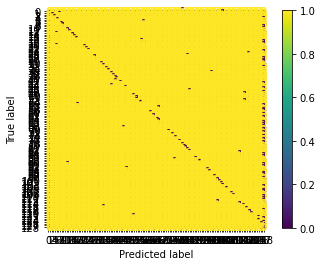

In [ ]:
if DO_TRAINING:
    S = model(next(dataset_val.take(1).as_numpy_iterator()), training=True)
    S_arr = S.numpy()
    ConfusionMatrixDisplay.from_predictions(
        y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Training history:

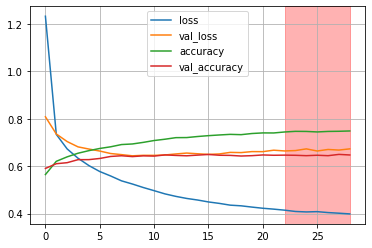

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.axvspan(len(history.history['loss'])-7, len(history.history['loss'])-1, color='red', alpha=0.3)

# Evaluation

First of all, we load the weights of the trained model.

In [25]:
# Load the obtained weights
model.load_weights(checkpoint_path, options=local_device_option)

We load the encodings of the dataset splits in memory.

In [32]:
representations_dir = os.path.join(datasets_dir, 'representations')
os.makedirs(representations_dir, exist_ok=True)

#### Test

In [33]:
if OVERRIDE_REPRESENTATIONS:
    test_paragraphs_encodings = np.stack([
            model.enc.model_p(tokenizer_distilbert(
                test_paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
                return_tensors='tf', truncation = True, padding = 'max_length'
            ))[0,0,:].numpy().astype(np.float32) 
        for i in tqdm(range(len(test_paragraphs)))
    ])
    np.save(os.path.join(representations_dir, 'test_paragraphs_encodings'), test_paragraphs_encodings)

test_paragraphs_encodings = np.load(os.path.join(representations_dir, 'test_paragraphs_encodings.npy'), allow_pickle=True)

In [34]:
test_paragraphs_encodings.shape, test_paragraphs_encodings.dtype

((2067, 768), dtype('float32'))

### Val

In [ ]:
if OVERRIDE_REPRESENTATIONS:
    val_paragraphs_encodings = np.zeros(shape=(len(val_paragraphs), BERT_DIMENSIONALITY), dtype=np.float32)
    for i in tqdm(range(len(val_paragraphs))):
        val_paragraphs_encodings[i] = model.enc.model_p(tokenizer_distilbert(
            val_paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
            return_tensors='tf', truncation = True, padding = 'max_length'
        ))[0,0,:].numpy().astype(np.float32)
    np.save(os.path.join(representations_dir, 'val_paragraphs_encodings.npy'), val_paragraphs_encodings)

val_paragraphs_encodings = np.load(os.path.join(representations_dir, 'val_paragraphs_encodings.npy'))

In [ ]:
val_paragraphs_encodings.shape, val_paragraphs_encodings.dtype

### Train

In [ ]:
if OVERRIDE_REPRESENTATIONS:
    train_paragraphs_encodings = np.zeros(shape=(len(train_paragraphs), BERT_DIMENSIONALITY), dtype=np.float32)
    for i in tqdm(range(len(train_paragraphs))):
        train_paragraphs_encodings[i] = model.enc.model_p(tokenizer_distilbert(
            train_paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
            return_tensors='tf', truncation = True, padding = 'max_length'
        ))[0,0,:].numpy().astype(np.float32)
    np.save(os.path.join(representations_dir, 'train_paragraphs_encodings.npy'), train_paragraphs_encodings)

train_paragraphs_encodings = np.load(os.path.join(representations_dir, 'train_paragraphs_encodings.npy'))

In [ ]:
train_paragraphs_encodings.shape, train_paragraphs_encodings.dtype

### Qualitative test

We select some random questions from the test set and see whether the selected paragraph is the correct one.

In [39]:
from utils import get_context_ids_from_top_indices

sample_question = random.choice(test_questions)
question_text = sample_question['qas']['question']
tokenized_question = tokenizer_distilbert(question_text, return_tensors="tf")
paragraph_id = sample_question['context_id']
print(f"Question: {question_text}")
print(f"Ground truth paragraph: {get_paragraph_from_question(sample_question, test_paragraphs_and_questions)['context']}")
print(f"Ground truth index: {paragraph_id}")
sample_q_repr = model.enc.model_q(tokenized_question)[:,0,:]
print(f"Question representation shape: {sample_q_repr.shape}")
scores = tf.tensordot(sample_q_repr, test_paragraphs_encodings.T, axes=1)
best_par_index = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :5].numpy()
print(f"Top-5 best matching paragraphs have ids {get_context_ids_from_top_indices(test_paragraphs, best_par_index)}")
print(f"Top-5 best matching paragraphs:")
for i in range(5):
    print(f"{i})\t{test_paragraphs[best_par_index[i]]['context']}")

Question: What are more common in other plastids than chloroplasts?
Ground truth paragraph: The chloroplast membranes sometimes protrude out into the cytoplasm, forming a stromule, or stroma-containing tubule. Stromules are very rare in chloroplasts, and are much more common in other plastids like chromoplasts and amyloplasts in petals and roots, respectively. They may exist to increase the chloroplast's surface area for cross-membrane transport, because they are often branched and tangled with the endoplasmic reticulum. When they were first observed in 1962, some plant biologists dismissed the structures as artifactual, claiming that stromules were just oddly shaped chloroplasts with constricted regions or dividing chloroplasts. However, there is a growing body of evidence that stromules are functional, integral features of plant cell plastids, not merely artifacts.
Ground truth index: (39, 31)
Question representation shape: (1, 768)
Top-5 best matching paragraphs have ids [(39, 28), 

Usually, the correct paragraphs show up in the Top-5 list, or very similar paragraphs appear instead.

### Quantitative test

Here we check the available data to understand what's the best way to combine them and compute scores and other statistics regarding the DPR.

In [ ]:
scores_dir = os.path.join(datasets_dir, 'scores')
os.makedirs(scores_dir, exist_ok=True)

In [ ]:
train_questions_encodings = np.load(os.path.join(representations_dir, 'train_questions_encodings.npy'))
val_questions_encodings = np.load(os.path.join(representations_dir, 'val_questions_encodings.npy'))
test_questions_encodings = np.load(os.path.join(representations_dir, 'test_questions_encodings.npy'))
print(train_questions_encodings.shape, val_questions_encodings.shape,test_questions_encodings.shape)

(65064, 768) (22535, 768) (10570, 768)


In [ ]:
def get_paragraph_encoding_index(question, dataset):
    '''
    Returns the index of the gt paragraph/context
    '''
    art_id, par_id = question['context_id']
    idx = sum([len(dataset[i]['paragraphs']) for i in range(art_id)]) + par_id
    return idx

def get_scores(k, question_set, paragraphs_and_question_set, question_encodings, paragraphs_encodings, vectorizer, docs_vectorized):
    '''
    Returns gt_ids for each question and the scores from both the DPR and Tf-Idf for all the paragraphs in relation to that question
    '''
    gts, dprs, tfidfs = [], [], []
    for i, q in enumerate(tqdm(question_set)):

        gt_id = get_paragraph_encoding_index(q, paragraphs_and_question_set)
        sample_q_repr = question_encodings[i]
        dpr_scores = np.dot(sample_q_repr, paragraphs_encodings.T) 
        question_text = q['qas']['question']
        vect_question = vectorizer.transform([question_text])
        TfIdf_scores = np.asarray(np.dot(docs_vectorized, vect_question.T).todense()).flatten()
        
        gts.append(gt_id)
        dprs.append(dpr_scores)
        tfidfs.append(TfIdf_scores)

    return gts, dprs, tfidfs

if OVERRIDE_SCORES:
    train_results = get_scores(1, train_questions, train_paragraphs_and_questions, train_questions_encodings, train_paragraphs_encodings, final_vectorizer, train_docs_vect)
    val_results = get_scores(1, val_questions, val_paragraphs_and_questions, val_questions_encodings, val_paragraphs_encodings, final_vectorizer, val_docs_vect)
    test_results = get_scores(1, test_questions, test_paragraphs_and_questions, test_questions_encodings, test_paragraphs_encodings, final_vectorizer, test_docs_vect)

    np.save(os.path.join(scores_dir, 'train_scores.npy'), train_results)
    np.save(os.path.join(scores_dir, 'val_scores.npy'), val_results)
    np.save(os.path.join(scores_dir, 'test_scores.npy'), test_results)

else:
    # You need a LOT of RAM to load the train_results
    train_results = np.load(os.path.join(scores_dir, 'train_scores.npy'), allow_pickle=True)
    val_results = np.load(os.path.join(scores_dir, 'val_scores.npy'), allow_pickle=True)
    test_results = np.load(os.path.join(scores_dir, 'test_scores.npy'), allow_pickle=True)


In [ ]:
gts, dprs, tfidfs = train_results
k = 5
dprs = [np.sort(x) for x in dprs]
tfidfs = [np.sort(x) for x in tfidfs]

dpr_mean = [np.mean(x) for x in dprs]
tfidf_mean = [np.mean(x) for x in tfidfs]

dpr_top5 = [np.mean(x[-k:]) for x in dprs]
tfidf_top5 = [np.mean(x[-k:]) for x in tfidfs]

dpr_mean_normalized = [np.mean(x/np.max(x)) for x in dprs]
tfidf_mean_normalized = [np.mean(x/np.max(x)) for x in tfidfs]

dpr_top5_normalized = [np.mean(x[-k:]/np.max(x)) for x in dprs]
tfidf_top5_normalized = [np.mean(x[-k:]/np.max(x)) for x in tfidfs]

dpr_mean_normalized2 = [np.mean((x-np.min(x))/np.max(x)) for x in dprs]
tfidf_mean_normalized2 = [np.mean((x-np.min(x))/np.max(x)) for x in tfidfs]

dpr_top5_normalized2 = [np.mean((x[-k:]-np.min(x))/np.max(x)) for x in dprs]
tfidf_top5_normalized2 = [np.mean((x[-k:]-np.min(x))/np.max(x)) for x in tfidfs]

/tmp/ipykernel_3265/1376111047.py:13: RuntimeWarning: invalid value encountered in divide
  tfidf_mean_normalized = [np.mean(x/np.max(x)) for x in tfidfs]
/tmp/ipykernel_3265/1376111047.py:16: RuntimeWarning: invalid value encountered in divide
  tfidf_top5_normalized = [np.mean(x[-k:]/np.max(x)) for x in tfidfs]
/tmp/ipykernel_3265/1376111047.py:19: RuntimeWarning: invalid value encountered in divide
  tfidf_mean_normalized2 = [np.mean((x-np.min(x))/np.max(x)) for x in tfidfs]
/tmp/ipykernel_3265/1376111047.py:22: RuntimeWarning: invalid value encountered in divide
  tfidf_top5_normalized2 = [np.mean((x[-k:]-np.min(x))/np.max(x)) for x in tfidfs]


In [ ]:
dpr_top5_standardized = [np.mean((x[-k:]-np.mean(x))/np.std(x)) for x in dprs]
tfidf_top5_standardized = [np.mean((x[-k:]-np.mean(x))/np.mean(x)) for x in tfidfs]

dpr_top5_standardized = np.sort(dpr_top5_standardized)
tfidf_top5_standardized = np.sort(tfidf_top5_standardized)

/tmp/ipykernel_3265/3673167267.py:2: RuntimeWarning: invalid value encountered in divide
  tfidf_top5_standardized = [np.mean((x[-k:]-np.mean(x))/np.mean(x)) for x in tfidfs]


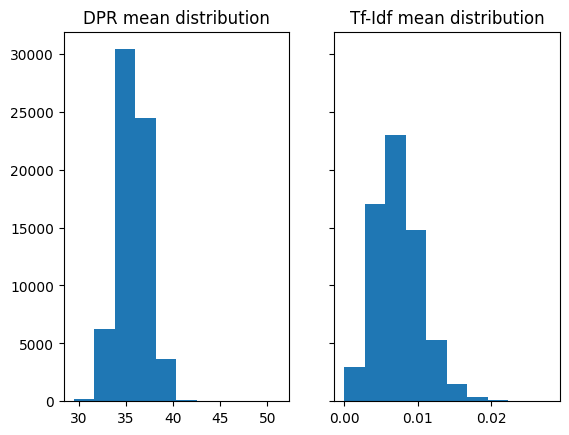

In [ ]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dpr_mean)
ax1.set_title("DPR mean distribution")
ax2.hist(tfidf_mean)
ax2.set_title("Tf-Idf mean distribution")
ax1.label_outer()
ax2.set_ylim(ax1.get_ylim())
ax2.label_outer()
plt.show()

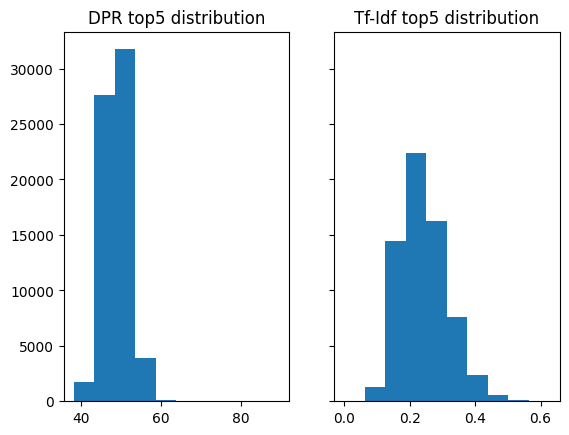

In [ ]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dpr_top5)
ax1.set_title("DPR top5 distribution")
ax2.hist(tfidf_top5)
ax2.set_title("Tf-Idf top5 distribution")
ax1.label_outer()
ax2.set_ylim(ax1.get_ylim())
ax2.label_outer()
plt.show()

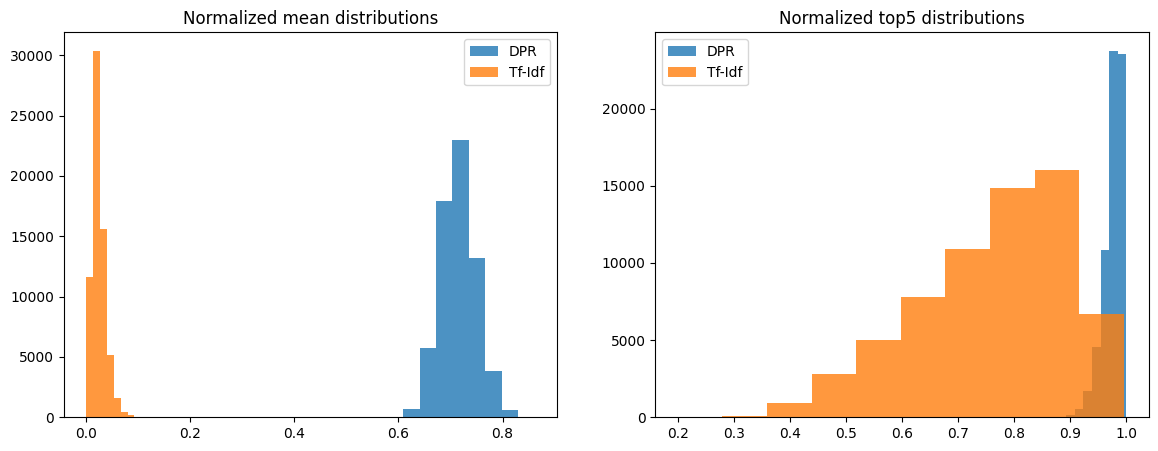

In [ ]:
%matplotlib inline

bins = np.linspace(0.8, 1, 100)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14,5)

ax1.set_title("Normalized mean distributions")
ax1.hist(dpr_mean_normalized, alpha=0.8, label="DPR")
ax1.hist(tfidf_mean_normalized, alpha=0.8, label="Tf-Idf")
ax1.legend()

ax2.set_title("Normalized top5 distributions")
ax2.hist(dpr_top5_normalized, alpha=0.8, label="DPR")
ax2.hist(tfidf_top5_normalized, alpha=0.8, label="Tf-Idf")
ax2.legend()

plt.show()

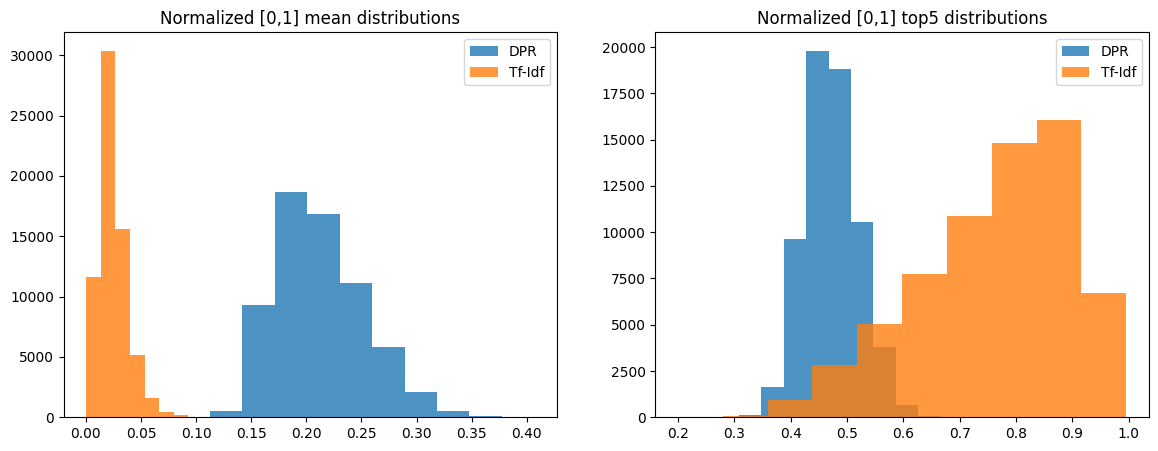

In [ ]:
%matplotlib inline

bins = np.linspace(0.8, 1, 100)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14,5)

ax1.set_title("Normalized [0,1] mean distributions")
ax1.hist(dpr_mean_normalized2, alpha=0.8, label="DPR")
ax1.hist(tfidf_mean_normalized2, alpha=0.8, label="Tf-Idf")
ax1.legend()

ax2.set_title("Normalized [0,1] top5 distributions")
ax2.hist(dpr_top5_normalized2, alpha=0.8, label="DPR")
ax2.hist(tfidf_top5_normalized2, alpha=0.8, label="Tf-Idf")
ax2.legend()

plt.show()

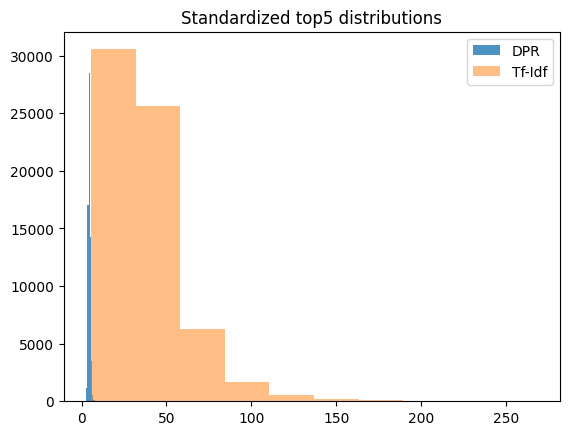

In [ ]:
%matplotlib inline

plt.title("Standardized top5 distributions")
(n, bins, patches) = plt.hist(dpr_top5_standardized, alpha=0.8, label="DPR")
plt.hist(tfidf_top5_standardized[:-10], alpha=0.5, label="Tf-Idf")
plt.legend()
plt.show()

In [ ]:
def update_counts(gt, top_k, matrix):
    for idx in top_k:
        matrix[gt, idx] += 1
    

def compute_counts(results, indexes_size, top_k_list = [1], hyperparam = None, full=True):
    gts, dprs, tfidfs = results

    counts = {}
    for k in top_k_list:
        if full:
            counts[k] = {
                "dpr": np.zeros((indexes_size, indexes_size)),
                "tfidf": np.zeros((indexes_size, indexes_size)),
                "sum": np.zeros((indexes_size, indexes_size)),
                "max": np.zeros((indexes_size, indexes_size))
            }
            if hyperparam != None:
                counts[k]["w_sum"] = np.zeros((indexes_size, indexes_size))
        else:
            counts[k] = np.zeros((indexes_size, indexes_size))

    if full:
        iterator = tqdm(zip(gts, dprs, tfidfs))
    else:
        iterator = zip(gts, dprs, tfidfs)

    for gt, dpr_scores, tfidf_scores in iterator:

        if full:
            normalized_dpr_scores = dpr_scores/np.max(dpr_scores)
            normalized_tfidf_scores = tfidf_scores/np.max(tfidf_scores)

            dpr_idx = np.argsort(dpr_scores)
            tfidf_idx = np.argsort(tfidf_scores)
            sum_idx = np.argsort(normalized_dpr_scores + normalized_tfidf_scores)
            max_idx = np.argsort([max(d, t) for d, t in zip(normalized_dpr_scores, normalized_tfidf_scores)])

            if hyperparam != None:
                standardized_dpr_scores = (dpr_scores-np.mean(dpr_scores))/np.std(dpr_scores)
                standardized_tfidf_scores = (tfidf_scores-np.mean(tfidf_scores))/np.std(tfidf_scores)
                weighed_sum = np.argsort(standardized_dpr_scores*(1-hyperparam) + standardized_tfidf_scores*hyperparam)

        else:
            standardized_dpr_scores = (dpr_scores-np.mean(dpr_scores))/np.std(dpr_scores)
            standardized_tfidf_scores = (tfidf_scores-np.mean(tfidf_scores))/np.std(tfidf_scores)
            weighed_sum = np.argsort(standardized_dpr_scores*(1-hyperparam) + standardized_tfidf_scores*hyperparam)

        for k in top_k_list:
            if full:
                update_counts(gt, dpr_idx[-k:], counts[k]["dpr"])
                update_counts(gt, tfidf_idx[-k:], counts[k]["tfidf"])
                update_counts(gt, sum_idx[-k:], counts[k]["sum"])
                update_counts(gt, max_idx[-k:], counts[k]["max"])
                if hyperparam != None:
                    update_counts(gt, weighed_sum[-k:], counts[k]["w_sum"])
                                        
            else:
                update_counts(gt, weighed_sum[-k:], counts[k])

    return counts


In [ ]:
def metrics(matrix, k=1):
    diag = matrix.diagonal()    

    accuracy = sum(diag) * k / matrix.sum() # because matrix.sum() / k = number of total samples to predict (each sample corresponds to k predictions) 

    if k == 1:

        precisions =    [d/s if s!=0 else 0 for d,s in zip(diag,matrix.sum(axis=0))] # how many times we predicted correctly paragraph x when we predict paragraph x? 
        # d times! divided by the number of times that, in general, we predicted that a paragraph was that paragraph

        recalls =       [d/s if s!=0 else 0 for d,s in zip(diag,matrix.sum(axis=1))] # how many times paragraph x has been correctly predicted when it was actually the gt?
        # d times! divided by the numbe of times that it was the gt, that is the sum over the ROWS of all the values (divided by how many values you insert each time, k)
        
        f1s = [2*p*r/(p+r) if p+r!=0 else 0 for p,r in zip(precisions, recalls)]

        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1s)

        return {
            "acc":accuracy, 
            "macro-precision":macro_precision, 
            "macro-recall":macro_recall, 
            "macro-f1":macro_f1
        }
    
    else:
        return accuracy

In [ ]:
def print_metrics(counts, top_k_list):
    for k in top_k_list:
        print(k)
        for key in counts[k].keys():
            print(key, metrics(counts[k][key], k))

Val

In [ ]:
def get_accuracies_hyperparam(results, top_k_list, hyperparam_range = np.arange(0.05, 1, 0.05)):
    opt = {}
    # for hyperparam in hyperparam_range:
    for hyperparam in tqdm(hyperparam_range):
        counts = compute_counts(results, len(val_paragraphs), top_k_list, hyperparam, full=False)
        opt[hyperparam] = {}
        for k in top_k_list:
            if k == 1:
                opt[hyperparam][k] = metrics(counts[k], k)["acc"]
            else:
                opt[hyperparam][k] = metrics(counts[k], k)
    return opt

In [ ]:
top_k_list = [1, 5, 20, 100]

hyperparam_range = np.arange(0.05, 1, 0.05)

opt = get_accuracies_hyperparam(val_results, top_k_list, hyperparam_range)

  0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_19417/1677794207.py:46: RuntimeWarning: invalid value encountered in divide
  standardized_tfidf_scores = (tfidf_scores-np.mean(tfidf_scores))/np.std(tfidf_scores)
100%|██████████| 19/19 [02:43<00:00,  8.60s/it]


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

def print_graph_optimization(opt, top_k_list, hyperparam_range):
    for k in top_k_list:
        plt.plot(
            [h for h in hyperparam_range], 
            [opt[h][k] for h in hyperparam_range],
            label = "k = {:.0f}".format(k),
        )

    plt.title("DPR*(1-h) + Tf-Idf*h")
    plt.xlabel("h")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

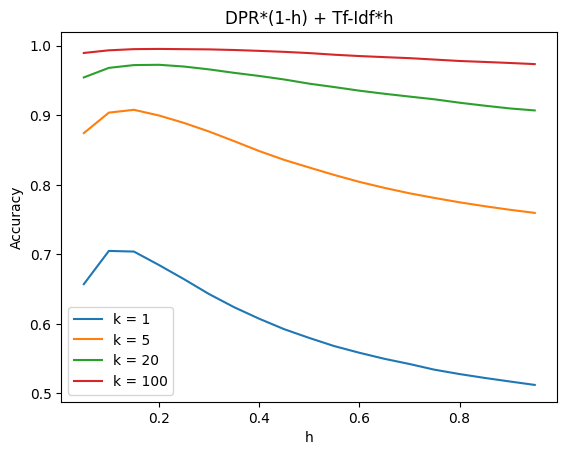

In [ ]:
print_graph_optimization(opt, top_k_list, hyperparam_range)

Left = DPR

Right = Tf-Idf

In [ ]:
for k in top_k_list:
    print("k: {}, max h: {}".format(k, hyperparam_range[ np.argmax([opt[h][k] for h in hyperparam_range]) ]))

k: 1, max h: 0.1
k: 5, max h: 0.15000000000000002
k: 20, max h: 0.2
k: 100, max h: 0.2


Test

In [ ]:
hyperparam_range = np.linspace(0.075, 0.225, 100)
opt = get_accuracies_hyperparam(val_results, top_k_list, hyperparam_range)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_19417/1677794207.py:46: RuntimeWarning: invalid value encountered in divide
  standardized_tfidf_scores = (tfidf_scores-np.mean(tfidf_scores))/np.std(tfidf_scores)
100%|██████████| 100/100 [14:03<00:00,  8.44s/it]


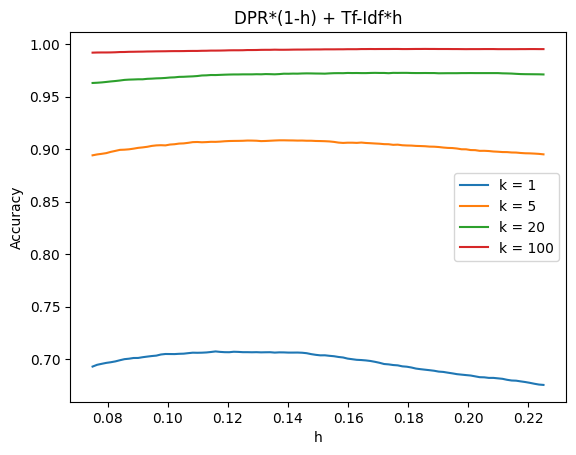

In [ ]:
print_graph_optimization(opt, top_k_list, hyperparam_range)

In [ ]:
for k in top_k_list:
    print("k: {}, max h: {}".format(k, hyperparam_range[ np.argmax([opt[h][k] for h in hyperparam_range]) ]))

k: 1, max h: 0.1159090909090909
k: 5, max h: 0.13712121212121214
k: 20, max h: 0.16893939393939394
k: 100, max h: 0.1856060606060606


DPR is better than Tf-Idf but, as could be imagined, when k is bigger tf-idf has more possibilities in finding the right paragraph

In [ ]:
hyperparam = 0.14
top_k_list = [1, 5, 20, 100]

In [ ]:
test_results = np.load(os.path.join(scores_dir, 'test_scores.npy'), allow_pickle=True)
counts = compute_counts(test_results, len(test_paragraphs), top_k_list, hyperparam=hyperparam)
print_metrics(counts, top_k_list)

10570it [00:14, 728.90it/s]


1
dpr {'acc': 0.4784295175023652, 'macro-precision': 0.5400666101582802, 'macro-recall': 0.4850251390513467, 'macro-f1': 0.46431192768270596}
tfidf {'acc': 0.5137180700094608, 'macro-precision': 0.6383863138472958, 'macro-recall': 0.5259952255553096, 'macro-f1': 0.5257225439024367}
sum {'acc': 0.5738883632923368, 'macro-precision': 0.6791081224374254, 'macro-recall': 0.5865125592105682, 'macro-f1': 0.5841735966221445}
max {'acc': 0.4964995269631031, 'macro-precision': 0.571440153650348, 'macro-recall': 0.5062339345043403, 'macro-f1': 0.49916059656692247}
w_sum {'acc': 0.6956480605487227, 'macro-precision': 0.7559416464905105, 'macro-recall': 0.710520452480632, 'macro-f1': 0.7007320293632027}
5
dpr 0.7793755912961211
tfidf 0.7487228003784295
sum 0.8138126773888363
max 0.8503311258278146
w_sum 0.9140964995269631
20
dpr 0.9359508041627247
tfidf 0.9018921475875118
sum 0.9391674550614948
max 0.956953642384106
w_sum 0.9785241248817408
100
dpr 0.9929044465468306
tfidf 0.9746452223273415
sum 0

Accuracy scores for the Dense Passage Retriever are:

- Top 1 score: 47.84%
- Top 5 score: 77.94%
- Top 20 score: 93.59%
- Top 100 score: 99.29%

The Tf-Idf model instead reached:

- Top 1 score: 51.37%
- Top 5 score: 74.87%
- Top 20 score: 90.19%
- Top 100 score: 97.46%

So we already have better results, which proves that the DPR is in general better at generalising.

# Saving intermediate results

We will pre-compute all of our questions' encodings with `model_q` so that we can easily access them later.

In [ ]:
from collections import deque

precomputed_encodings = {
    'train': {
        'questions': train_questions,
        'encodings': deque([])
    }, 
    'val': {
        'questions': val_questions,
        'encodings': deque([])
    },
    'test': {
        'questions': test_questions,
        'encodings': deque([])
    }
}

In [ ]:
if OVERRIDE_REPRESENTATIONS:
    for key in precomputed_encodings:
        question_set = precomputed_encodings[key]['questions']
        for i,q in enumerate(tqdm(question_set)):
            # Tokenize the question
            tok_q = tokenizer_distilbert(
                q['qas']['question'], max_length = MAX_SEQ_LEN, 
                return_tensors='tf', truncation = True, padding = 'max_length'
            )
            # Pass the tokens through the question encoder
            q_repr = model.enc.model_q(tok_q)[:,0,:].numpy()
            # Append the computed embedding into the matrix for the respective set
            precomputed_encodings[key]['encodings'].append(np.squeeze(q_repr))
        # Save the matrix of precomputed values
        encoding_matrix = np.stack(list(precomputed_encodings[key]['encodings']))
        np.save(os.path.join(representations_dir, f'{key}_questions_encodings.npy'), encoding_matrix)

100%|██████████| 10570/10570 [13:02<00:00, 13.51it/s]
